In [11]:
# Donald Nguyen
# Created 09/28/2021

# Imports
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits

from fits_loader import FitsFileLoader
from vels_loader import VelsLoader_CCF
from line_list_loader import LineListLoader_Wise
from line_list_loader import LineListLoader_VALD

%matplotlib inline

# Functions

@np.vectorize
def wavelength_air2vac(wavelength_air): 
    '''
    Wavelength in vacuum from wavelength in air in units of Angstroms (from VALD)
    '''
    s = 1e4 / wavelength_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s * s) + 0.0001599740894897 / (38.92568793293 - s * s)
    return wavelength_air * n

@np.vectorize
def wavelength_vac2air(wavelength):
    s = 1e4 / wavelength
    return wavelength / (1 + 0.0000834254 + 0.02406147 / (130 - s * s) + 0.00015998 / (38.9 - s * s))

@np.vectorize
def wavelength_rvshift(rv_cm_per_s):
    '''
    Wavelength in rest frame from wavelength in observed frame and relativistic radial velocity in units of cm/s
    '''
    return np.sqrt(1 - rv_cm_per_s / 29979245800) / np.sqrt(1 + rv_cm_per_s / 29979245800)

In [12]:
# Load fits files and vels/ccf files
loader = FitsFileLoader()
vloader = VelsLoader_CCF('34411')

# Create list of pd.DataFrames and velocities for each fits file
datas = [loader.data_from_single_fits(filepath, 1) for filepath in loader.filepaths]
vels = [vloader.velocity_from_fits(filename) for filename in loader.filenames]
assert(len(datas) == len(vels))

rv_shifts = [wavelength_rvshift(vel['v']) for vel in vels]

# Create list of pd.Series of rv corrected wavelengths, continuums, and spectra for each fits file
#   vels[0]['units'] = 'cm/s'
wavelengths = [datas[i]['bary_wavelength'] * rv_shifts[i] for i in np.arange(len(datas))]
continuums = [data['continuum'] for data in datas]
spectra = [data['spectrum'] for data in datas]

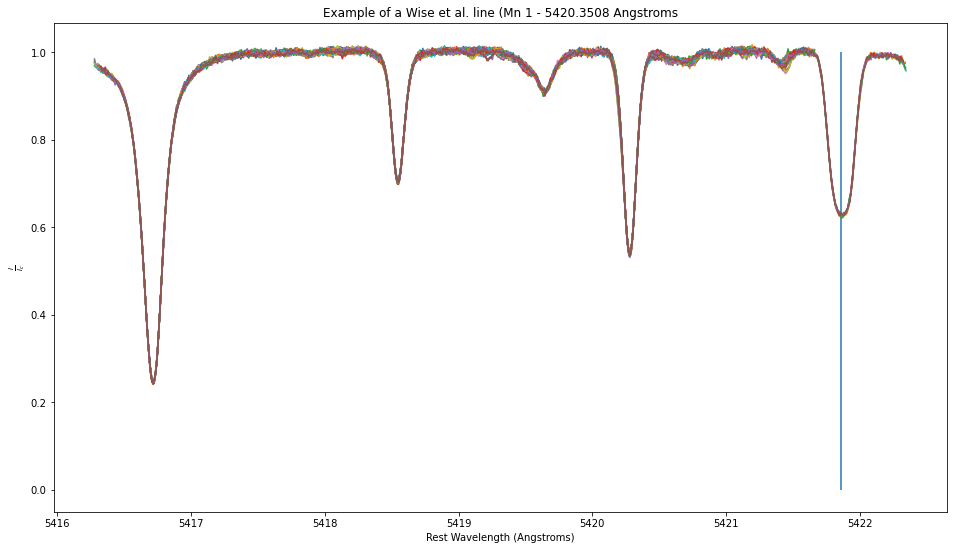

In [13]:
# Example plot of a Wise et al. line (Mn 1 5420.3508 A)
obs_ex = []
order_ex = 47
obs_range_ex = (3500, 4000)
for i in range(len(wavelengths)):
    obs_ex.append(spectra[i][order_ex, obs_range_ex[0]:obs_range_ex[1]] / continuums[i][order_ex, obs_range_ex[0]:obs_range_ex[1]])

plt.figure(figsize=(16, 9))
for wavelength, ob in zip(wavelengths, obs_ex):
    plt.plot(wavelength[order_ex, obs_range_ex[0]:obs_range_ex[1]], ob)
plt.vlines(wavelength_air2vac(5420.3508), 0, 1)
plt.title('Example of a Wise et al. line (Mn 1 - 5420.3508 Angstroms')
plt.xlabel('Rest Wavelength (Angstroms)')
plt.ylabel(r'$\frac{I}{I_c}$')
plt.show()

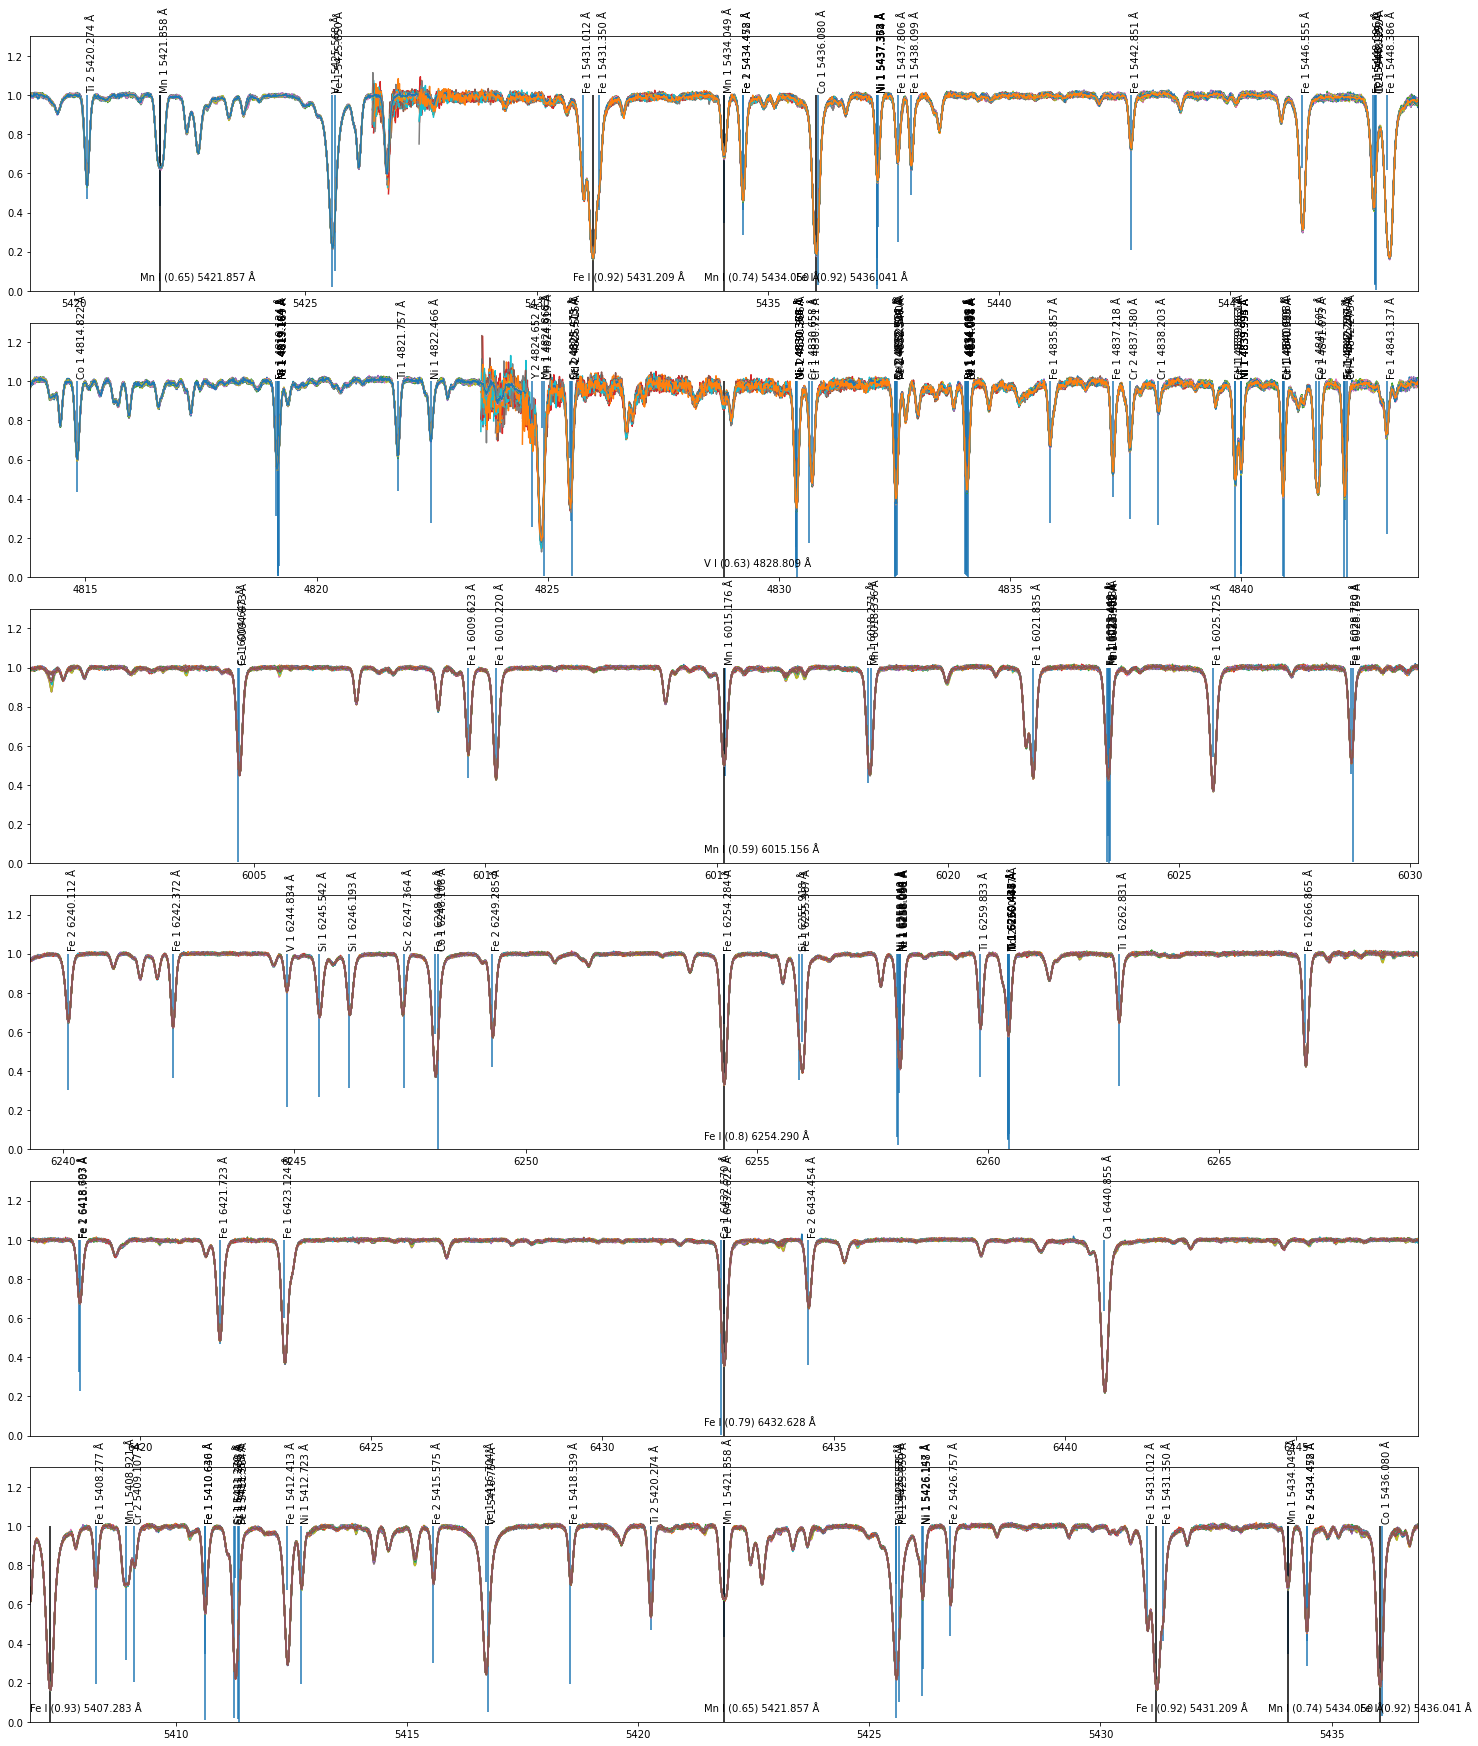

In [14]:
from scipy.interpolate import interp1d                            

min_VALD_depth = 0.5
max_VALD_depth = 0.8

wise_lines = LineListLoader_Wise()
chosen_lines = wise_lines.list_VALD_depths(min_VALD_depth, max_VALD_depth)
#print(chosen_lines)

vald_lines = LineListLoader_VALD().dataframe

obs = [spectra[i] / continuums[i] for i in np.arange(len(wavelengths))]

chosen_lines_positions = {}

for chosen_line in chosen_lines['Wavelength']: # Wavelengths in air
    chosen_lines_positions[chosen_line] = []
    for ind_file, (wavelength, ob) in enumerate(zip(wavelengths, obs)):
        for order in np.arange(len(wavelength)):
            if wavelength[order, 0] <= wavelength_air2vac(chosen_line) <= wavelength[order, -1]:
                chosen_lines_positions[chosen_line].append((ind_file, order))

fig, axes = plt.subplots(chosen_lines['Wavelength'].count(), 1, figsize =(20, 24))
plt.tight_layout()
wave_range = 30
for ax, (chosen_line_index, chosen_line), positions in zip(axes, chosen_lines.iterrows(), chosen_lines_positions.values()):
    chosen_line_vac = wavelength_air2vac(chosen_line['Wavelength'])
    lower_bound = chosen_line_vac - wave_range / 2
    upper_bound = chosen_line_vac + wave_range / 2

    ax.set_xlim(lower_bound, upper_bound)
    ax.set_ylim(0, 1.3)

    x = np.array([])
    y = np.array([])
    for ind_file, order in positions:
        x = np.concatenate((x, wavelengths[ind_file][order]))
        y = np.concatenate((y, obs[ind_file][order]))
        
        ax.plot(wavelengths[ind_file][order], obs[ind_file][order])
    grid = np.column_stack((x, y))
    sorted_grid = grid[np.argsort(grid[:, 0])]
    sorted_grid = sorted_grid[~np.isnan(sorted_grid[:, 1])]
    #print(sorted_grid[:15])
    spline = interp1d(grid[:, 0], grid[:, 1], kind='linear')
    
    for index, vald_line in vald_lines[(vald_lines['WL_vac(A)'] >= lower_bound) & (vald_lines['WL_vac(A)'] <= upper_bound)].iterrows():
        depth_range = 0.6
        lower_depth = spline(vald_line['WL_vac(A)']) - depth_range
        upper_depth = spline(vald_line['WL_vac(A)']) + depth_range
        if lower_depth <= vald_line['Central depth'] <= upper_depth:
            ax.vlines(vald_line['WL_vac(A)'], vald_line['Central depth'], 1)
            ax.annotate(f"{vald_line['Spec Ion']}" + f" {vald_line['WL_vac(A)']:.3f} \u00C5", (vald_line['WL_vac(A)'], 1), xytext=(0, 5), textcoords='offset pixels', rotation=90)

    
    for chosen_line_index2, chosen_line2 in wise_lines.dataframe.iterrows():
        chosen_line_vac2 = wavelength_air2vac(chosen_line2['Wavelength'])
        if lower_bound <= chosen_line_vac2 <= upper_bound:
            ax.vlines(chosen_line_vac2, 0, 1, 'black')
            ax.annotate(f"{chosen_line2['Species_(VALD_Depth)']}" + f" {chosen_line_vac2:.3f} \u00C5", (chosen_line_vac2, 0), xytext=(-20, 10), textcoords='offset pixels')
plt.savefig('lines_on_34411_spectra.png', dpi=300)
plt.show()



In [15]:
wise_lines_vac = wise_lines.dataframe
wise_lines_vac['Wavelength'] = wavelength_air2vac(wise_lines_vac['Wavelength'])
print(wise_lines_vac)

      tau   Wavelength  epsilon_Eri_Slope  alpha_Cen_B_Slope  \
0   0.753  5111.844217              0.212              0.137   
1   0.733  4377.169663              0.205              0.140   
2   0.710  4428.563203              0.185              0.130   
3   0.702  4462.912259              0.176              0.110   
4   0.694  5013.478060              0.155              0.092   
5   0.685  5271.006597              0.102              0.110   
6   0.676  5398.630626              0.142              0.118   
7   0.673  5431.209319              0.129              0.132   
8   0.667  5508.309901              0.132              0.114   
9   0.667  4572.381156              0.147              0.073   
10  0.661  6564.622983              0.149              0.444   
11  0.645  5053.048579              0.134              0.092   
12  0.643  5372.993787              0.099              0.120   
13  0.639  5407.282935              0.105              0.121   
14  0.634  5502.998483              0.12

5442.851
5442.851
5442.851
5442.851
5442.851
5442.851


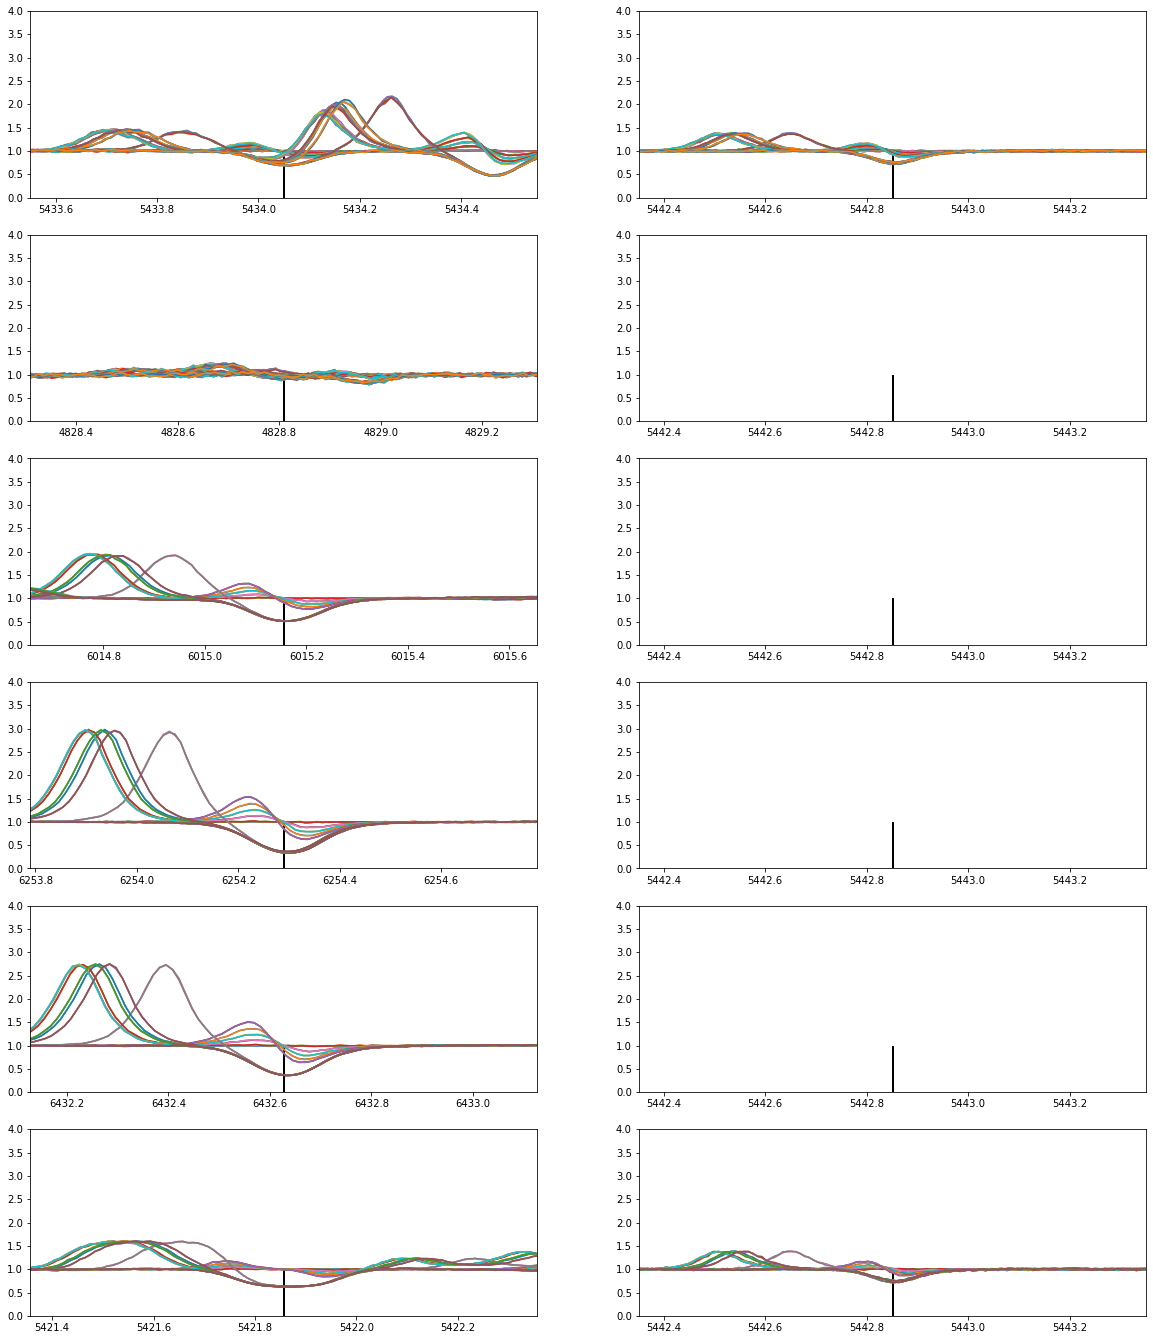

In [20]:
fig2, axes2 = plt.subplots(chosen_lines['Wavelength'].count(), 2, figsize =(20, 24))

active_lines = chosen_lines.copy()
active_lines['Wavelength'] = active_lines['Wavelength'].apply(wavelength_air2vac)
inactive_lines = vald_lines[~(vald_lines['WL_vac(A)'].apply(lambda x: round(x, 2))).isin(active_lines['Wavelength'].apply(lambda x: round(x, 2)))]

#print(inactive_lines[(inactive_lines['WL_vac(A)'] > 5442.5) & (inactive_lines['WL_vac(A)'] < 5442.9)])
#print(active_lines[(active_lines['Wavelength'] < 5434.1) & (active_lines['Wavelength'] > 5434.0)])
wave_range2 = 1
for ax, (active_line_index, active_line), positions in zip(axes2, active_lines.iterrows(), chosen_lines_positions.values()):
    # Plot active lines
    active_line_vac = active_line['Wavelength']
    active_lower_bound = active_line_vac - wave_range2 / 2
    active_upper_bound = active_line_vac + wave_range2 / 2
    ax[0].set_xlim(active_lower_bound, active_upper_bound)
    ax[0].set_ylim(0, 4)
    for ind_file, order in positions:
        ax[0].plot(wavelengths[ind_file][order], obs[ind_file][order] / obs[0][order])
        ax[0].vlines(active_line_vac, 0, 1, 'black')
    
    # Plot inactive lines
    depth_range2 = 0.6
    inactive_lower_depth = 0.206 - depth_range2
    inactive_upper_depth = 0.206 + depth_range2
    inactive_lines_depth_filter = (inactive_lines['Central depth'] >= inactive_lower_depth) & (inactive_lines['Central depth'] <= inactive_upper_depth)
    inactive_lines_range_filter = (inactive_lines['WL_vac(A)'] > 5442.5) & (inactive_lines['WL_vac(A)'] < 5442.9)

    inactive_line_vac = inactive_lines[(inactive_lines_depth_filter) & inactive_lines_range_filter]['WL_vac(A)'].values[-1]
    print(inactive_line_vac)
    inactive_lower_bound = inactive_line_vac - wave_range2 / 2
    inactive_upper_bound = inactive_line_vac + wave_range2 / 2
    ax[1].set_xlim(inactive_lower_bound, inactive_upper_bound)
    ax[1].set_ylim(0, 4)
    for ind_file, order in positions:
            ax[1].plot(wavelengths[ind_file][order], obs[ind_file][order] / obs[0][order])
            ax[1].vlines(inactive_line_vac, 0, 1, 'black')

plt.show()


In [17]:
hdu = fits.open(loader.filepaths[0])
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               799922 / length of dimension 1                          
NAXIS2  =                   86 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   17 / number of table fields                         
EXTNAME = 'optimal '           / Extraction algorithm                           
DATE-EXT= '2021-06-04T17:44:52.160' / Date and time of extraction               
SCATLGHT=                    T / Scattered light removed before extraction      
EXT_SIZE=                   33 / Size of the extraction window (pixels)         
FLAT_REL=                   

('VERSION', 'ID', 'TEFF', 'GRAV', 'FEH', 'VMIC', 'VMAC', 'VSINI', 'VRAD', 'VRAD_FLAG', 'CSCALE', 'CSCALE_FLAG', 'GAM6', 'H2BROAD', 'ACCWI', 'ACCRT', 'CLIM', 'MAXITER', 'CHIRAT', 'NMU', 'NSEG', 'ABUND', 'SPECIES', 'ATOMIC', 'LANDE', 'DEPTH', 'LINEREF', 'SHORT_LINE_FORMAT', 'WRAN', 'MU', 'ATMO', 'WAVE', 'WIND', 'SOB', 'UOB', 'MOB', 'OBS_NAME', 'OBS_TYPE', 'CINTB', 'CINTR', 'VMAC_PRO', 'SMOD', 'CMOD', 'JINT', 'WINT', 'SINT')


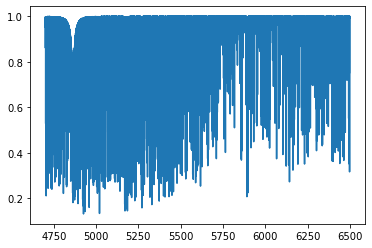

In [18]:
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import readsav

sme_out = readsav('sme/hd34411_4700_6500/hd34411_4700_6500.out', python_dict=False)
print(sme_out['sme'].dtype.names)

plt.figure()
plt.plot(sme_out['sme']['WAVE'][0], sme_out['sme']['SMOD'][0])